In [13]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
!pip install --upgrade shap

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
import pandas as pd
pd.set_option("display.max_columns",None)
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize":(18,8)},style='darkgrid')
sns.set_palette('rocket')
from time import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit

In [16]:
from sklearn.metrics import *

In [17]:
train=pd.read_csv("data/fraudTrain.csv")
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [18]:
test=pd.read_csv("data/fraudTest.csv")
test.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [19]:
test["split"]="test"
train["split"]="train"
df=pd.concat([train,test],axis=0).reset_index(drop=True)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


In [20]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  str    
 2   cc_num                 int64  
 3   merchant               str    
 4   category               str    
 5   amt                    float64
 6   first                  str    
 7   last                   str    
 8   gender                 str    
 9   street                 str    
 10  city                   str    
 11  state                  str    
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    str    
 17  dob                    str    
 18  trans_num              str    
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               int64 

In [21]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [22]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64

In [23]:
df.duplicated().sum()

np.int64(0)

In [24]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'split'],
      dtype='str')

In [25]:
df.drop(columns=['Unnamed: 0','first', 'last','trans_num','street','state'],inplace=True)
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud,split
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,M,Luray,63453,40.4931,-91.8912,519,Town planner,1966-02-13,1388534347,39.946837,-91.333331,0,test
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,M,Lake Jackson,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,1388534349,29.661049,-96.186633,0,test
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,F,Burbank,99323,46.1966,-118.9017,3684,Musician,1981-11-29,1388534355,46.658340,-119.715054,0,test
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,M,Mesa,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,1388534364,44.470525,-117.080888,0,test


In [26]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'],format='mixed')

In [27]:
# 1. Extract day of week (0=Monday, 6=Sunday)
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

# 2. Apply cyclical transformation (Period = 7)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [28]:
df['hour']=df['trans_date_trans_time'].dt.hour

In [29]:
fraud=df[df['is_fraud']==1]

In [30]:
df['dob']=pd.to_datetime(df['dob'],format='mixed')
df['age']=(df['trans_date_trans_time'].dt.year-df['dob'].dt.year).astype(int)

In [31]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud,split,day_of_week,day_sin,day_cos,hour,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0,train,1,0.781831,0.62349,0,31
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0,train,1,0.781831,0.62349,0,41
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0,train,1,0.781831,0.62349,0,57
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0,train,1,0.781831,0.62349,0,52
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0,train,1,0.781831,0.62349,0,33


In [32]:
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Radius of Earth in kilometers
    return round(km,2)

# Apply the Haversine formula
df['distance_km'] = df.apply(lambda row: haversine_distance(row['merch_lat'],row['merch_long'], row['lat'], row['long']), axis=1)

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud,split,day_of_week,day_sin,day_cos,hour,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0,train,1,0.781831,0.62349,0,31,78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0,train,1,0.781831,0.62349,0,41,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0,train,1,0.781831,0.62349,0,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0,train,1,0.781831,0.62349,0,52,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0,train,1,0.781831,0.62349,0,33,77.56


In [33]:
df.drop(columns=['dob','lat','long','merch_long','merch_lat'],inplace=True)

In [34]:
#SUMMARY STATS
df.describe().T

,count,mean,min,25%,50%,75%,max,std
trans_date_trans_time,1852394,2020-01-20 21:31:46.801827,2019-01-01 00:00:18,2019-07-23 04:13:43.750000,2020-01-02 01:15:31,2020-07-23 12:11:25.250000,2020-12-31 23:59:34,NaN
cc_num,1852394.0,417386038393710400.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0,1309115265318735104.0
amt,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
zip,1852394.0,48813.258191,1257.0,26237.0,48174.0,72042.0,99921.0,26881.845966
city_pop,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
unix_time,1852394.0,1358674218.834364,1325376018.0,1343016823.75,1357089331.0,1374581485.25,1388534374.0,18195081.38756
is_fraud,1852394.0,0.00521,0.0,0.0,0.0,0.0,1.0,0.071992
day_of_week,1852394.0,2.967456,0.0,1.0,3.0,5.0,6.0,2.197983
day_sin,1852394.0,-0.074649,-0.974928,-0.781831,0.0,0.433884,0.974928,0.685087
day_cos,1852394.0,0.147219,-0.900969,-0.222521,0.62349,0.62349,1.0,0.709514


In [35]:
#SUMMARY STATS
df.describe(include='object').T

,count,unique,top,freq
merchant,1852394,693,fraud_Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
city,1852394,906,Birmingham,8040
job,1852394,497,Film/video editor,13898
split,1852394,2,train,1296675


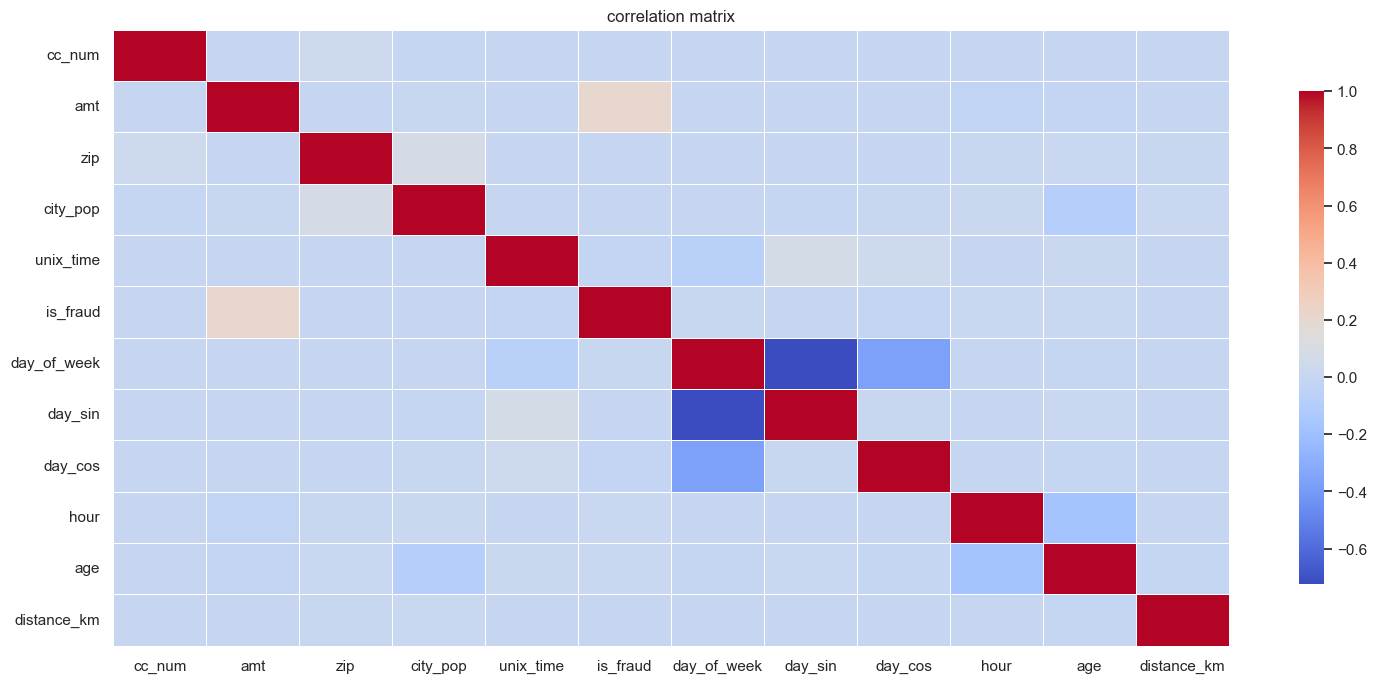

In [36]:
sns.heatmap(df.select_dtypes(include='number').corr(),annot=None,cmap='coolwarm',fmt='.2f',linewidth=0.5,cbar_kws={'shrink':0.8})
plt.title('correlation matrix')
plt.show()

In [37]:
df.select_dtypes(include='number').corr()

,cc_num,amt,zip,city_pop,unix_time,is_fraud,day_of_week,day_sin,day_cos,hour,age,distance_km
cc_num,1.000000,0.001826,0.041504,-0.009118,0.000284,-0.001125,-0.000851,0.002118,-0.002048,-0.000902,-0.000131,0.003082
amt,0.001826,1.000000,0.001979,0.004921,-0.002411,0.209308,0.000491,0.000473,-0.003301,-0.024891,-0.010695,-0.000538
zip,0.041504,0.001979,1.000000,0.077601,0.001017,-0.002190,-0.001021,0.001556,-0.000041,0.005947,0.010359,0.006750
city_pop,-0.009118,0.004921,0.077601,1.000000,-0.001636,0.000325,0.001180,-0.004184,0.006552,0.019949,-0.090889,0.010989
unix_time,0.000284,-0.002411,0.001017,-0.001636,1.000000,-0.013329,-0.072071,0.074955,0.042583,0.000571,0.020680,-0.000470
is_fraud,-0.001125,0.209308,-0.002190,0.000325,-0.013329,1.000000,0.004562,0.000906,-0.012312,0.013196,0.010927,0.000359
day_of_week,-0.000851,0.000491,-0.001021,0.001180,-0.072071,0.004562,1.000000,-0.723891,-0.368198,0.000584,-0.008918,-0.000092
day_sin,0.002118,0.000473,0.001556,-0.004184,0.074955,0.000906,-0.723891,1.000000,0.005635,-0.000647,0.010983,-0.000184
day_cos,-0.002048,-0.003301,-0.000041,0.006552,0.042583,-0.012312,-0.368198,0.005635,1.000000,0.002021,-0.004789,0.000526
hour,-0.000902,-0.024891,0.005947,0.019949,0.000571,0.013196,0.000584,-0.000647,0.002021,1.000000,-0.173014,0.000391


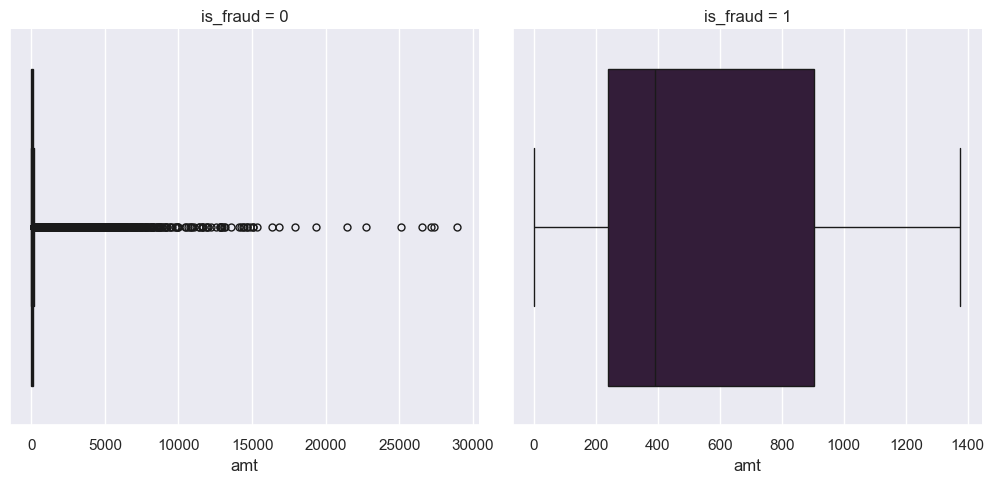

In [38]:
sns.catplot(data=df,x='amt',col='is_fraud',kind='box',sharex=False)

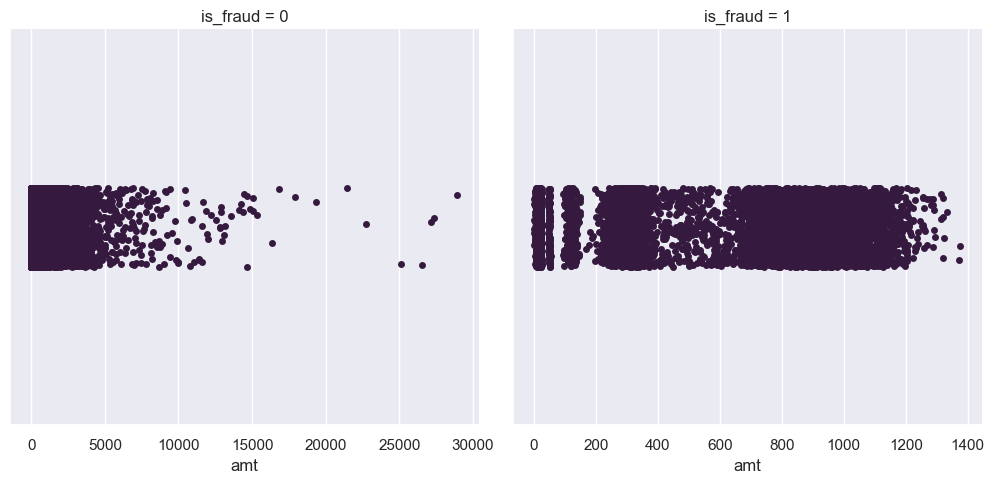

In [39]:
sns.catplot(data=df,x='amt',col='is_fraud',kind='strip',sharex=False)

In [40]:
def pie_bar_plot(col):
    print(df[col].value_counts())
    sns.set_palette("Spectral")
    fig,axs=plt.subplots(1,2)
    axs[0].pie(df[col].value_counts().values.tolist(),autopct="%.2f%%",textprops={'fontsize':25},shadow=True)
    sns.countplot(data=df,x=col,hue='is_fraud',palette=['blue','orange'],ax=axs[1])
    fig.legend(labels=df[col].value_counts().index.tolist(),loc='upper left',fontsize=20)
    fig.tight_layout()
    fig.show()

gender
F    1014749
M     837645
Name: count, dtype: int64


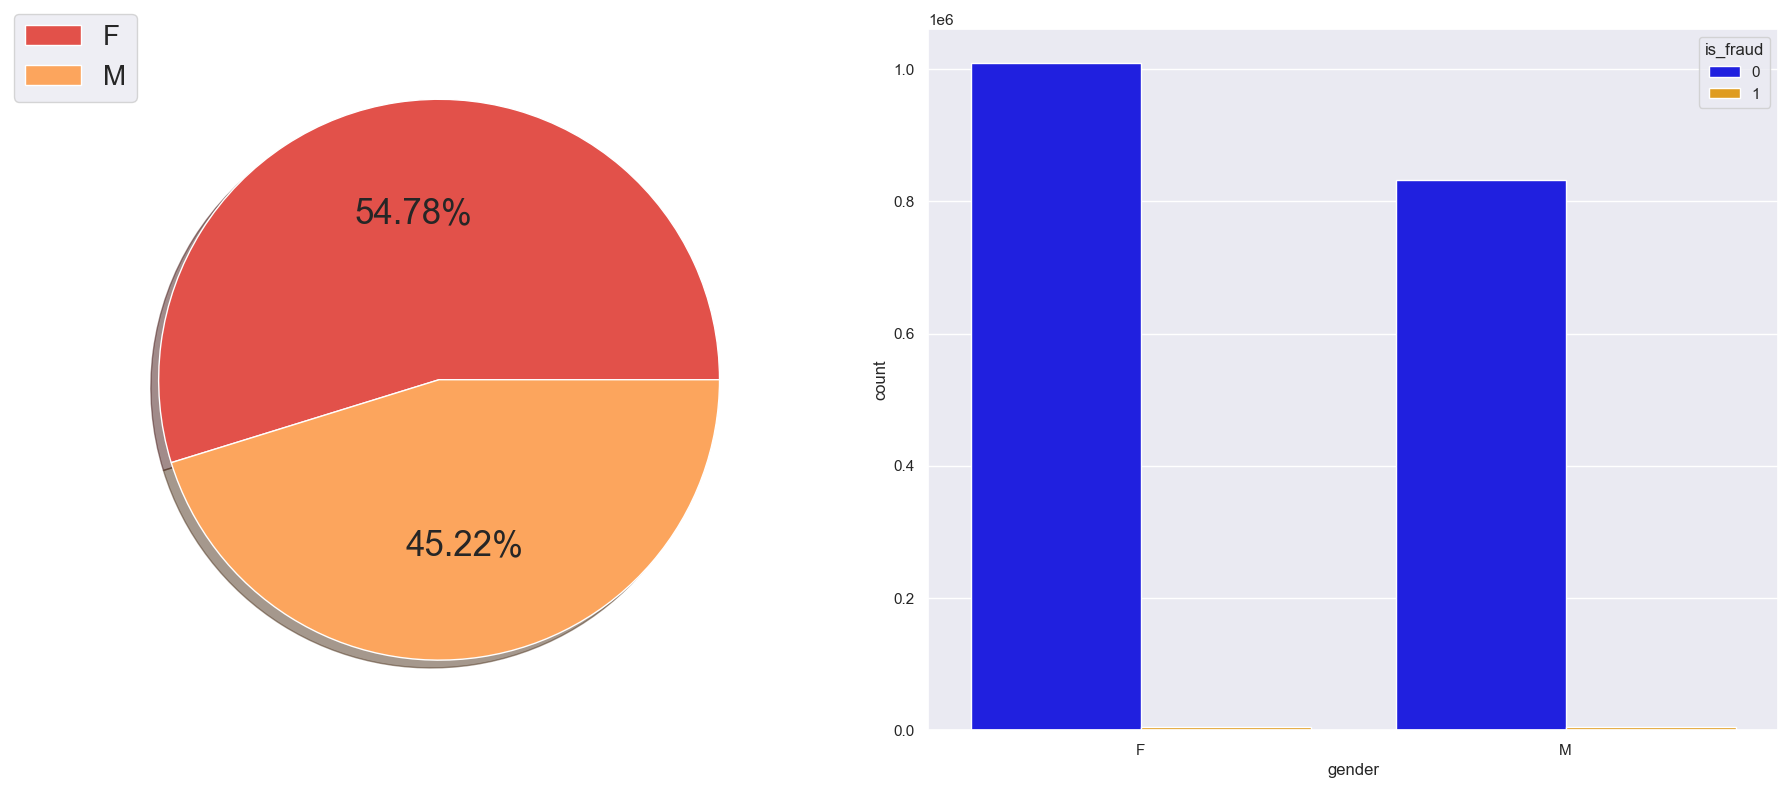

In [41]:
pie_bar_plot('gender')

is_fraud
0    1842743
1       9651
Name: count, dtype: int64


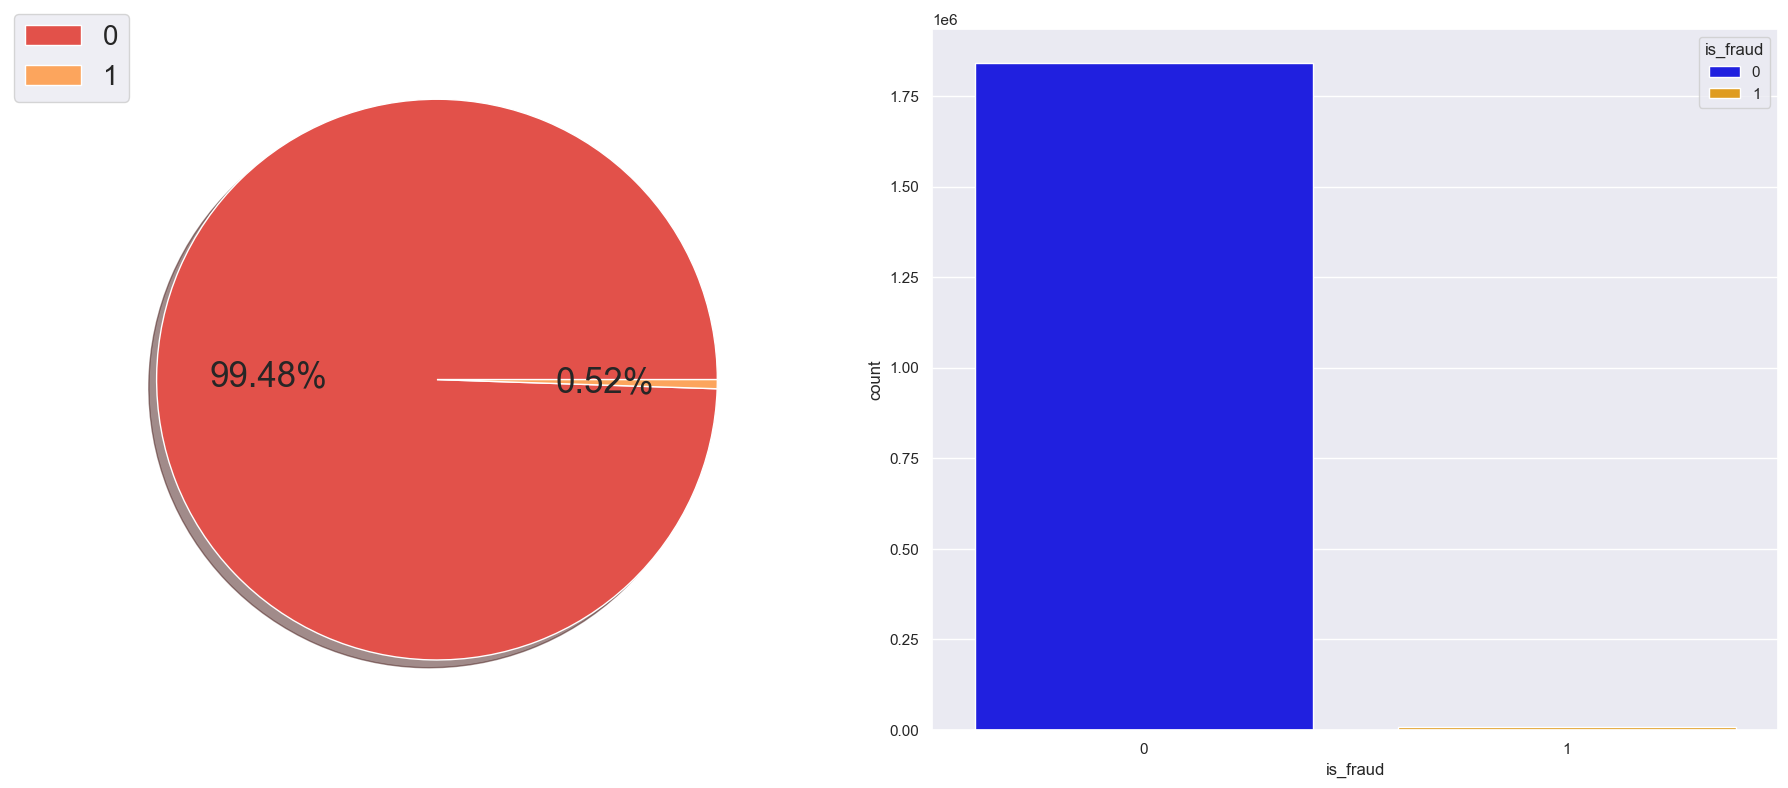

In [42]:
pie_bar_plot('is_fraud')

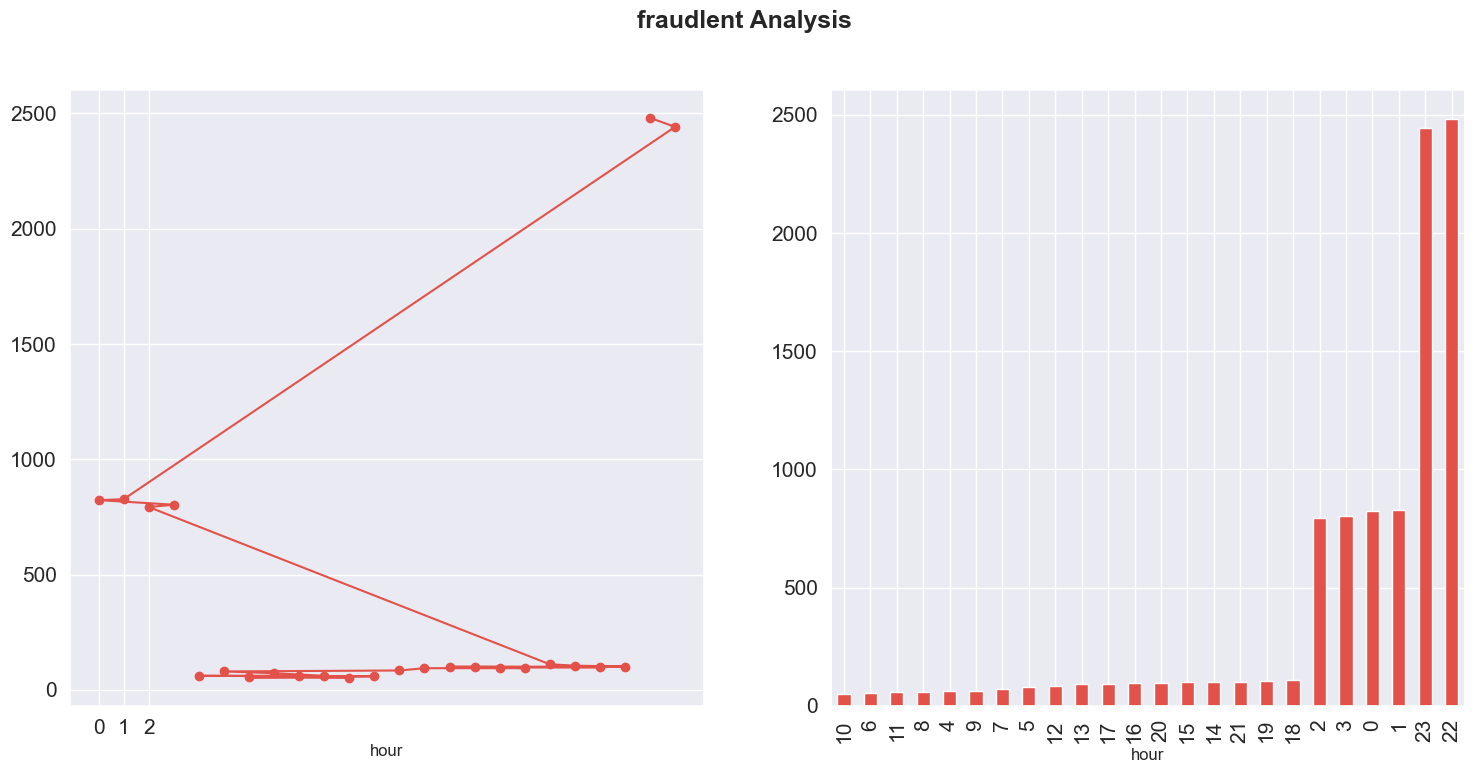

In [43]:
fig,axs=plt.subplots(1,2)
fig.suptitle("fraudlent Analysis",fontsize=18,fontweight='bold')
df.loc[df["is_fraud"]==1,'hour'].value_counts(ascending=True).plot(kind='line',ax=axs[0],marker='o',fontsize=15)
axs[0].set_xticks(range(0,3))
df.loc[df['is_fraud']==1,'hour'].value_counts(ascending=True).plot(kind='bar',ax=axs[1],fontsize=15)
plt.show()

In [44]:
df.loc[df['is_fraud']==1,['gender']].value_counts()

gender
F         4899
M         4752
Name: count, dtype: int64

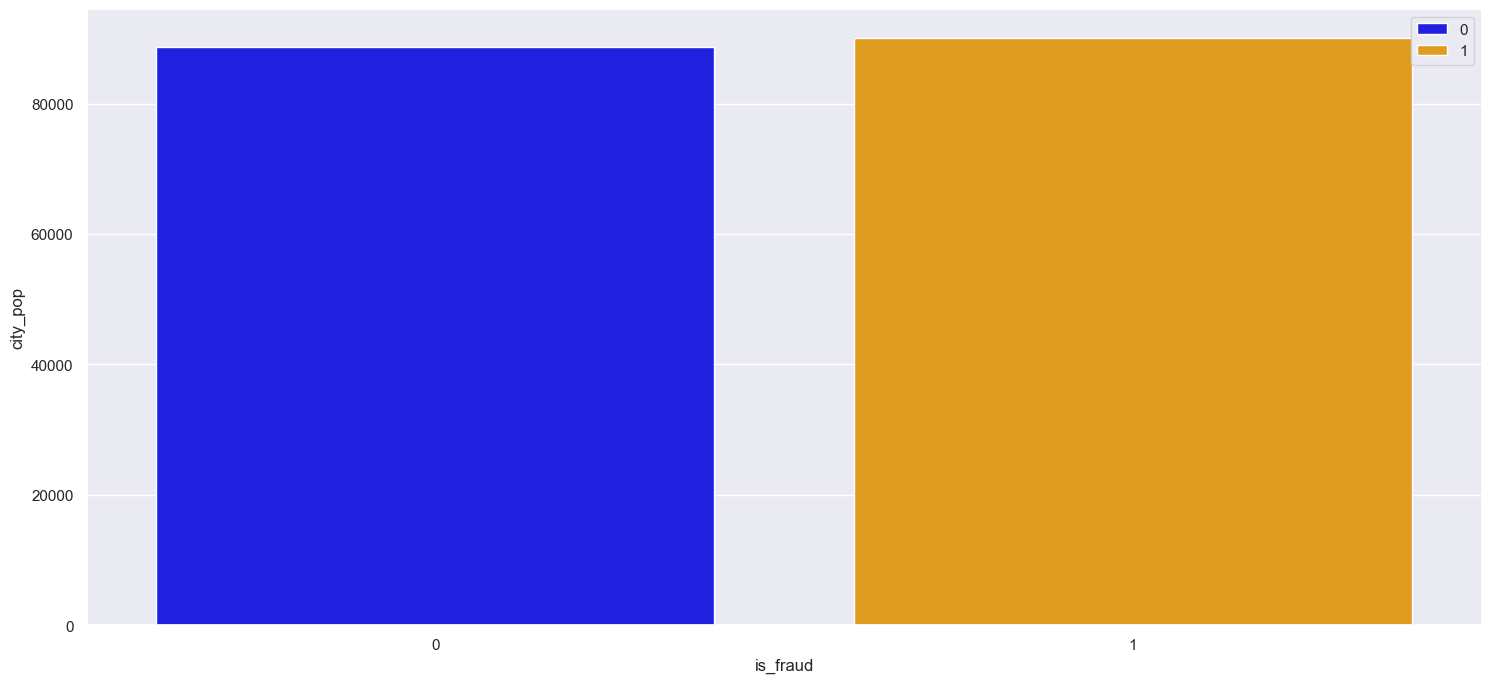

In [45]:
from scipy.stats import ttest_ind
sns.barplot(data=df,x='is_fraud',y='city_pop',hue='is_fraud',palette=['blue','orange'],ci=None)
plt.legend(loc='upper right')
plt.show()

In [46]:
f_pop=df[df['is_fraud']==1]['city_pop']
na_f_pop=df[df['is_fraud']==1]['city_pop']
t_stat,p_value=ttest_ind(f_pop,na_f_pop)
print(f'T-test: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,2)}, p-value<0.05? = {p_value<0.05}')

T-test: t-statistic = 0.0, p-value = 1.0, p-value<0.05? = False


Text(0, 0.5, 'Frequency')

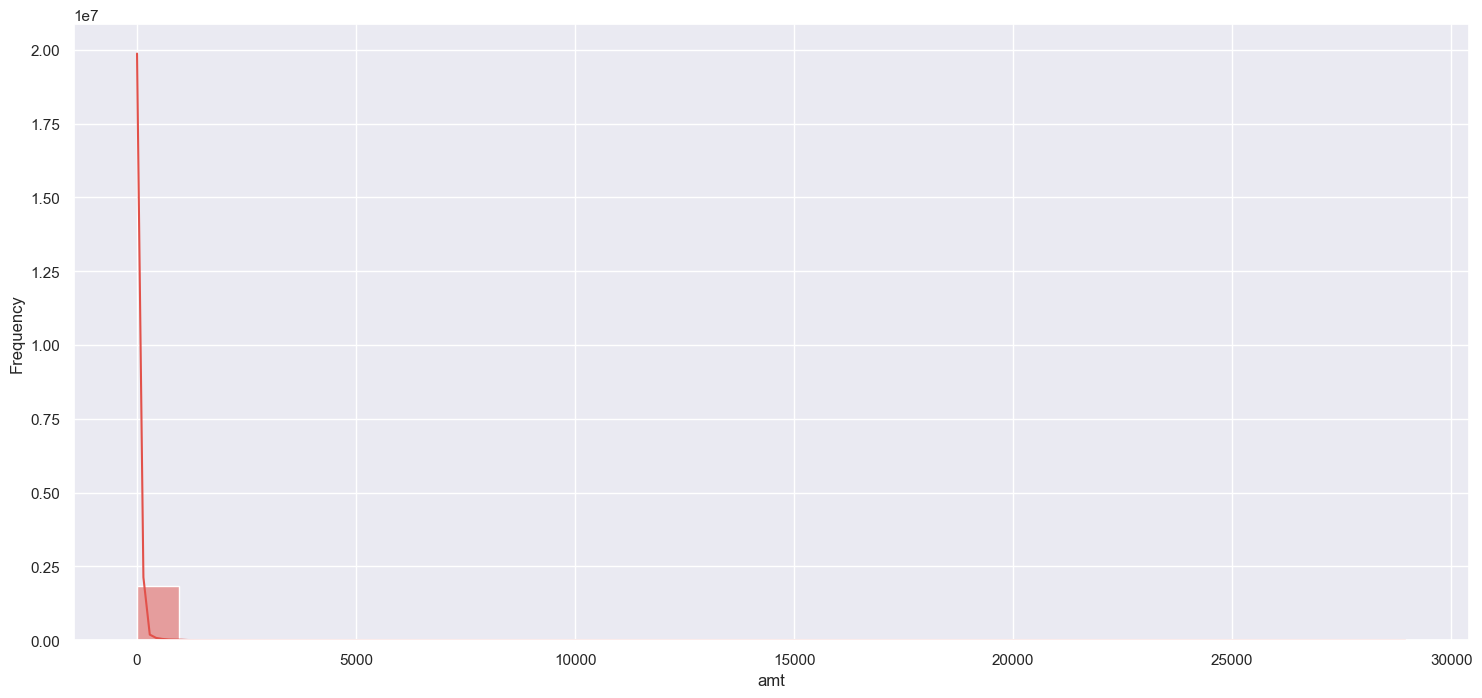

In [47]:
sns.histplot(data=df,x='amt',bins=30,kde=True)
plt.ylabel('Frequency')

In [48]:
df['gender_bin'] = df['gender'].map({'F': 0, 'M': 1})

In [49]:
#we will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df.sort_values(['cc_num','trans_date_trans_time'],inplace=True)
df['hours_diff_bet_trans']=((df.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))

In [50]:
df.loc[df['hours_diff_bet_trans'].isna(),'hours_diff_bet_trans']=0
df['hours_diff_bet_trans']=df['hours_diff_bet_trans'].astype(int)

In [51]:
from scipy import stats

t,p=stats.ttest_ind(df[df['is_fraud']==0]['hours_diff_bet_trans'],df[df['is_fraud']==1]['hours_diff_bet_trans'],alternative='two-sided')
print(t,p)

21.308600246531242 9.715494713958866e-101


In [52]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,unix_time,is_fraud,split,day_of_week,day_sin,day_cos,hour,age,distance_km,gender_bin,hours_diff_bet_trans
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,F,Fort Washakie,82514,1645,Information systems manager,1325422035,0,train,1,0.781831,0.623490,12,33,127.61,0,0
2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,F,Fort Washakie,82514,1645,Information systems manager,1325493897,0,train,2,0.974928,-0.222521,8,33,110.31,0,19
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,F,Fort Washakie,82514,1645,Information systems manager,1325494056,0,train,2,0.974928,-0.222521,8,33,21.79,0,0
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,F,Fort Washakie,82514,1645,Information systems manager,1325507894,0,train,2,0.974928,-0.222521,12,33,87.20,0,3
2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,F,Fort Washakie,82514,1645,Information systems manager,1325509846,0,train,2,0.974928,-0.222521,13,33,74.21,0,0


<Axes: xlabel='is_fraud', ylabel='hours_diff_bet_trans'>

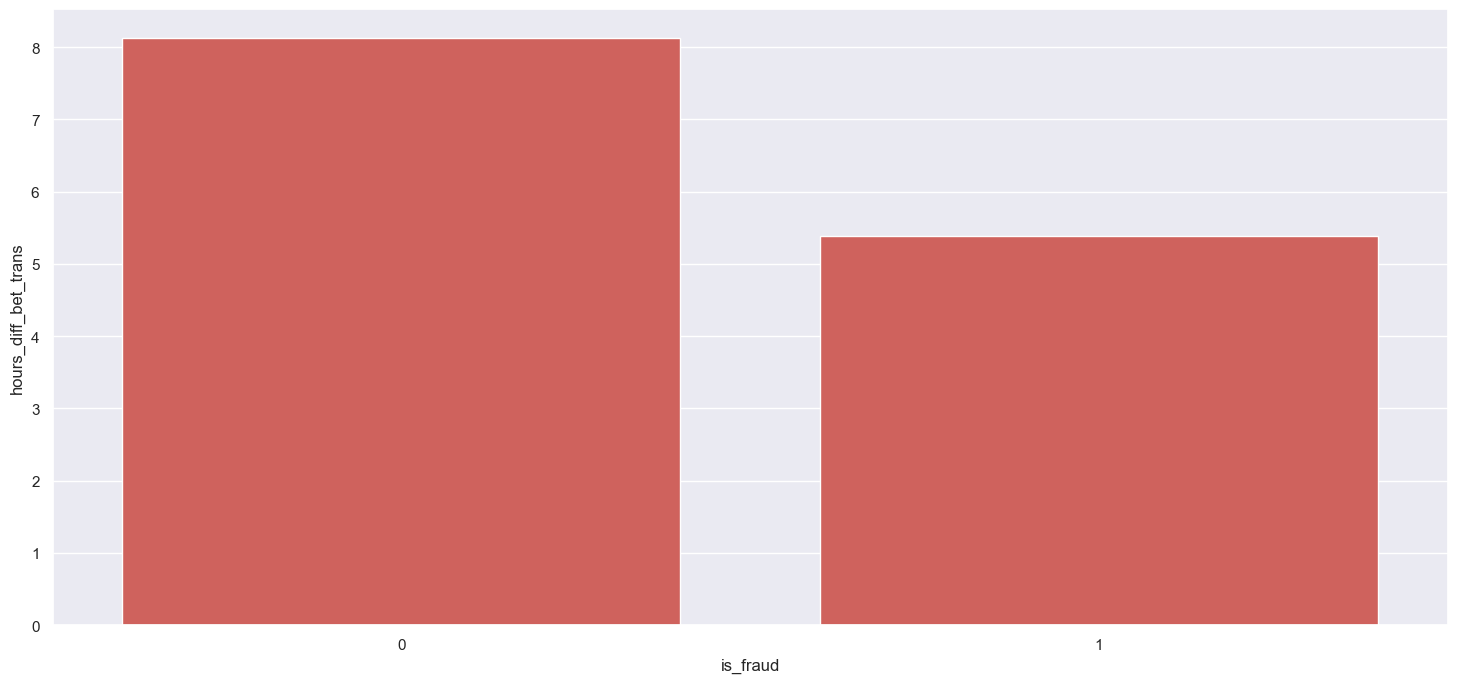

In [53]:
sns.barplot(data=df,x='is_fraud',y='hours_diff_bet_trans',ci=None)

In [54]:

df = df.sort_values(['cc_num', 'trans_date_trans_time'])
df = df.set_index('trans_date_trans_time')

# 1. Transaction Velocity (Rolling Count)
# Identifies sudden bursts in card usage
df['trans_count_24h'] = df.groupby('cc_num')['amt'].rolling('24h').count().shift(1).reset_index(0, drop=True).fillna(0)

# 2. Recent Spending Baseline (Rolling Mean)
# Needed for the 24h ratio calculation
df['avg_amt_24h'] = df.groupby('cc_num')['amt'].rolling('24h').mean().shift(1).reset_index(0, drop=True).fillna(df['amt'])

# 3. All-time Spending Profile (Expanding Mean)
# Captures long-term user behavior
df['user_avg_amt_all_time'] = df.groupby('cc_num')['amt'].transform(lambda x: x.expanding().mean().shift(1)).fillna(df['amt'])

# Reset index to restore dataframe structure
df = df.reset_index()

In [55]:
# Identifies spikes relative to recent 24-hour activity (Burst Detection)
df['amt_to_avg_ratio_24h'] = df['amt'] / df['avg_amt_24h']

# Identifies spikes relative to long-term behavior (Anomaly Detection)
df['amt_relative_to_all_time'] = df['amt'] / df['user_avg_amt_all_time']

In [56]:
# Apply cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df.drop(['hour'], axis=1, inplace=True)

df.drop('day_of_week', axis=1, inplace=True)

In [57]:
df = df.sort_values('trans_date_trans_time')
df['hours_diff_bet_trans_log'] = np.log1p(df['hours_diff_bet_trans'])
df.drop('hours_diff_bet_trans', axis=1, inplace=True)

In [58]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,unix_time,is_fraud,split,day_sin,day_cos,age,distance_km,gender_bin,trans_count_24h,avg_amt_24h,user_avg_amt_all_time,amt_to_avg_ratio_24h,amt_relative_to_all_time,hour_sin,hour_cos,hours_diff_bet_trans_log
839573,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",1325376018,0,train,0.781831,0.623490,31,78.60,0,6.0,95.641667,4.970000,0.051965,1.000000,0.000000,1.000000,0.000000
68160,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,1325376044,0,train,0.781831,0.623490,41,30.21,0,1.0,12.110000,107.230000,8.854666,1.000000,0.000000,1.000000,0.000000
443631,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,1325376051,0,train,0.781831,0.623490,57,108.21,1,5.0,445.778000,220.110000,0.493766,1.000000,0.000000,1.000000,0.000000
974884,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,1939,Patent attorney,1325376076,0,train,0.781831,0.623490,52,95.67,1,5.0,42.454000,45.000000,1.059971,1.000000,0.000000,1.000000,0.000000
702664,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,99,Dance movement psychotherapist,1325376186,0,train,0.781831,0.623490,33,77.56,1,6.0,78.120000,41.960000,0.537122,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394614,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,M,Luray,63453,519,Town planner,1388534347,0,test,0.433884,-0.900969,54,77.03,1,4.0,66.842500,62.356436,0.654823,0.701932,-0.258819,0.965926,1.609438
1038657,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,M,Lake Jackson,77566,28739,Futures trader,1388534349,0,test,0.433884,-0.900969,21,100.07,1,8.0,50.592500,50.435516,2.210604,2.217485,-0.258819,0.965926,1.098612
1608607,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,F,Burbank,99323,3684,Musician,1388534355,0,test,0.433884,-0.900969,39,80.76,0,8.0,94.298750,88.704797,0.921327,0.979428,-0.258819,0.965926,0.000000
146463,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,M,Mesa,83643,129,Cartographer,1388534364,0,test,0.433884,-0.900969,55,52.93,1,3.0,71.220000,61.016205,0.112188,0.130949,-0.258819,0.965926,1.386294


In [59]:
df.drop(columns=['cc_num','city_pop','unix_time','zip','merchant','gender'],inplace=True)

In [60]:
df.columns

Index(['trans_date_trans_time', 'category', 'amt', 'city', 'job', 'is_fraud',
       'split', 'day_sin', 'day_cos', 'age', 'distance_km', 'gender_bin',
       'trans_count_24h', 'avg_amt_24h', 'user_avg_amt_all_time',
       'amt_to_avg_ratio_24h', 'amt_relative_to_all_time', 'hour_sin',
       'hour_cos', 'hours_diff_bet_trans_log'],
      dtype='str')

In [61]:
df=df[['trans_date_trans_time','job','age','gender_bin','category','distance_km','hour_sin','hour_cos','day_sin','day_cos','hours_diff_bet_trans_log','amt','trans_count_24h','amt_to_avg_ratio_24h','amt_relative_to_all_time','is_fraud','split']]

In [62]:
df.to_csv('cleaned.csv',index=False)

In [63]:
df.head()

,trans_date_trans_time,job,age,gender_bin,category,distance_km,hour_sin,hour_cos,day_sin,day_cos,hours_diff_bet_trans_log,amt,trans_count_24h,amt_to_avg_ratio_24h,amt_relative_to_all_time,is_fraud,split
839573,2019-01-01 00:00:18,"Psychologist, counselling",31,0,misc_net,78.60,0.0,1.0,0.781831,0.62349,0.0,4.97,6.0,0.051965,1.0,0,train
68160,2019-01-01 00:00:44,Special educational needs teacher,41,0,grocery_pos,30.21,0.0,1.0,0.781831,0.62349,0.0,107.23,1.0,8.854666,1.0,0,train
443631,2019-01-01 00:00:51,Nature conservation officer,57,1,entertainment,108.21,0.0,1.0,0.781831,0.62349,0.0,220.11,5.0,0.493766,1.0,0,train
974884,2019-01-01 00:01:16,Patent attorney,52,1,gas_transport,95.67,0.0,1.0,0.781831,0.62349,0.0,45.00,5.0,1.059971,1.0,0,train
702664,2019-01-01 00:03:06,Dance movement psychotherapist,33,1,misc_pos,77.56,0.0,1.0,0.781831,0.62349,0.0,41.96,6.0,0.537122,1.0,0,train


In [64]:
df['job'].unique()

<StringArray>
[        'Psychologist, counselling', 'Special educational needs teacher',
       'Nature conservation officer',                   'Patent attorney',
    'Dance movement psychotherapist',                 'Transport planner',
                   'Arboriculturist',              'Designer, multimedia',
         'Public affairs consultant',                       'Pathologist',
 ...
                   'Careers adviser',               'Information officer',
                       'Ship broker',                   'Legal secretary',
                         'Homeopath',                         'Solicitor',
                 'Warehouse manager',                   'Engineer, water',
     'Operational investment banker',                 'Software engineer']
Length: 497, dtype: str

In [65]:
df['category'].unique()

<StringArray>
[      'misc_net',    'grocery_pos',  'entertainment',  'gas_transport',
       'misc_pos',    'grocery_net',   'shopping_net',   'shopping_pos',
    'food_dining',  'personal_care', 'health_fitness',         'travel',
      'kids_pets',           'home']
Length: 14, dtype: str

In [66]:
df=pd.read_csv('cleaned.csv')

In [67]:
df.head()

,trans_date_trans_time,job,age,gender_bin,category,distance_km,hour_sin,hour_cos,day_sin,day_cos,hours_diff_bet_trans_log,amt,trans_count_24h,amt_to_avg_ratio_24h,amt_relative_to_all_time,is_fraud,split
0,2019-01-01 00:00:18,"Psychologist, counselling",31,0,misc_net,78.60,0.0,1.0,0.781831,0.62349,0.0,4.97,6.0,0.051965,1.0,0,train
1,2019-01-01 00:00:44,Special educational needs teacher,41,0,grocery_pos,30.21,0.0,1.0,0.781831,0.62349,0.0,107.23,1.0,8.854666,1.0,0,train
2,2019-01-01 00:00:51,Nature conservation officer,57,1,entertainment,108.21,0.0,1.0,0.781831,0.62349,0.0,220.11,5.0,0.493766,1.0,0,train
3,2019-01-01 00:01:16,Patent attorney,52,1,gas_transport,95.67,0.0,1.0,0.781831,0.62349,0.0,45.00,5.0,1.059971,1.0,0,train
4,2019-01-01 00:03:06,Dance movement psychotherapist,33,1,misc_pos,77.56,0.0,1.0,0.781831,0.62349,0.0,41.96,6.0,0.537122,1.0,0,train


In [68]:
from category_encoders import WOEEncoder
from xgboost import XGBClassifier
df['amt_log'] = np.log1p(df['amt'])
# 4. TEMPORAL SPLIT (75% Train, 25% Test)
train_size = int(len(df) * 0.75)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# 5. Weight of Evidence Encoding (Fit on Train ONLY to prevent leakage)
woe_cols = ['job', 'category']
encoder = WOEEncoder(cols=woe_cols)

# Fit on training data and target
encoder.fit(train_df[woe_cols], train_df['is_fraud'])

# Transform both sets
train_encoded = encoder.transform(train_df[woe_cols]).add_suffix('_woe')
test_encoded = encoder.transform(test_df[woe_cols]).add_suffix('_woe')

train_df = pd.concat([train_df, train_encoded], axis=1)
test_df = pd.concat([test_df, test_encoded], axis=1)

# 6. Final Feature Selection
features = [
    'amt_log',                   # Normalized transaction value
    'age',                       # User demographic
    'gender_bin',                # Binary demographic
    'distance_km',               # Spatial anomaly indicator
    'hours_diff_bet_trans_log',  # Log-transformed velocity signal
    'hour_sin', 'hour_cos',      # Cyclical daily time
    'day_sin', 'day_cos',        # Cyclical weekly time (ADD THESE)
    'job_woe',                   # Risk-encoded profession
    'category_woe',              # Risk-encoded category
    'trans_count_24h',           # Recent transaction burst count
    'amt_to_avg_ratio_24h',      # Deviation from 24h spending norm
    'amt_relative_to_all_time'   # Deviation from long-term spending norm
]

X_train, y_train = train_df[features], train_df['is_fraud']
X_test, y_test = test_df[features], test_df['is_fraud']

# 7. MODEL TRAINING: COST-SENSITIVE XGBOOST
# Calculate scale_pos_weight to handle 0.5% imbalance
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost') #
# 1. Define Parameter Grid for Optimization
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# 2. Setup TimeSeriesSplit
# This ensures each fold uses a training set that precedes the validation set in time
tscv = TimeSeriesSplit(n_splits=5)

# 3. Run GridSearchCV
# Scoring is set to 'average_precision' (PR-AUC) as it is more robust than ROC-AUC for fraud
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        scale_pos_weight=imbalance_ratio, 
        tree_method='hist', 
         device='cuda',
        random_state=42
       
    ),
    param_grid=param_grid,
    cv=tscv,
    scoring='average_precision', 
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# 4. Extract Best Parameters
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# 5. Final Training
# Train on the entire 75% training set using optimized parameters
best_model.fit(X_train, y_train)

# 6. Final Evaluation on 25% Unseen Test Set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision-Recall Analysis
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

print(f"Final Test PR-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [21:01:15] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [21:01:16] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Final Test PR-AUC: 0.9978


In [ ]:
# Select threshold where recall is at least 80% while maximizing precision
idx = np.where(recall >= 0.80)[0][-1]
optimal_threshold = thresholds[idx]

y_final_pred = (y_pred_proba >= optimal_threshold).astype(int)
print(f"Optimal Threshold: {optimal_threshold}")
print(classification_report(y_test, y_final_pred))

Optimal Threshold: 0.9016819596290588
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    461339
           1       0.96      0.80      0.87      1760

    accuracy                           1.00    463099
   macro avg       0.98      0.90      0.94    463099
weighted avg       1.00      1.00      1.00    463099



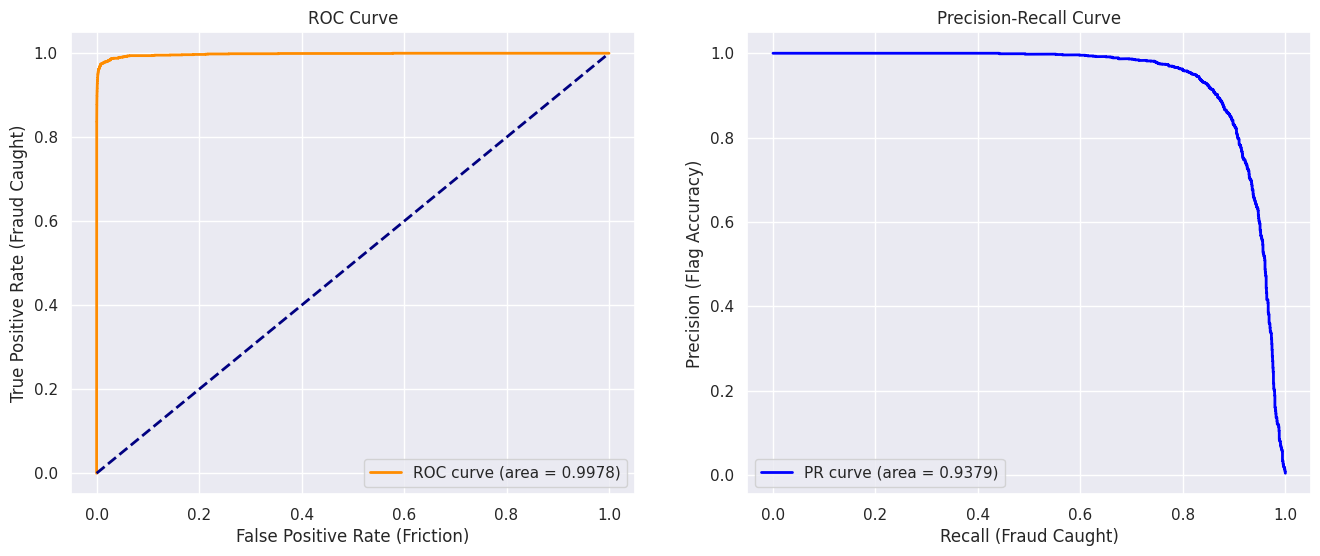

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC data
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate PR data
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlabel('False Positive Rate (Friction)')
ax[0].set_ylabel('True Positive Rate (Fraud Caught)')
ax[0].set_title('ROC Curve')
ax[0].legend(loc="lower right")

# Precision-Recall Curve
ax[1].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
ax[1].set_xlabel('Recall (Fraud Caught)')
ax[1].set_ylabel('Precision (Flag Accuracy)')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()

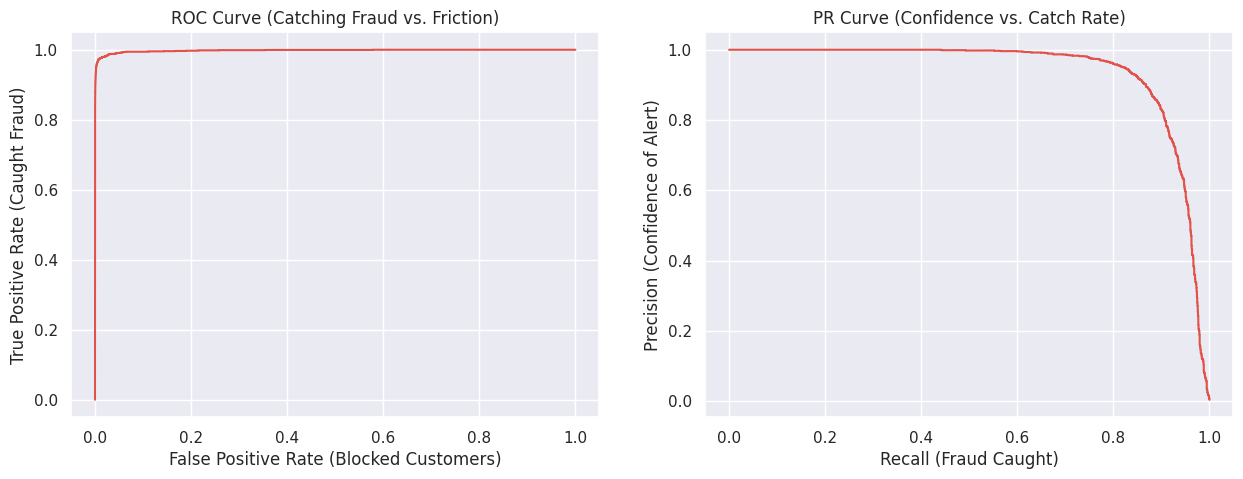

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Get values
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plotting
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC Plot
ax1.plot(fpr, tpr, label='XGBoost (AUC = 0.998)')
ax1.set_title('ROC Curve (Catching Fraud vs. Friction)')
ax1.set_xlabel('False Positive Rate (Blocked Customers)')
ax1.set_ylabel('True Positive Rate (Caught Fraud)')

# PR Plot
ax2.plot(recall, precision, label='XGBoost (PR-AUC = 0.998)')
ax2.set_title('PR Curve (Confidence vs. Catch Rate)')
ax2.set_xlabel('Recall (Fraud Caught)')
ax2.set_ylabel('Precision (Confidence of Alert)')

plt.show()

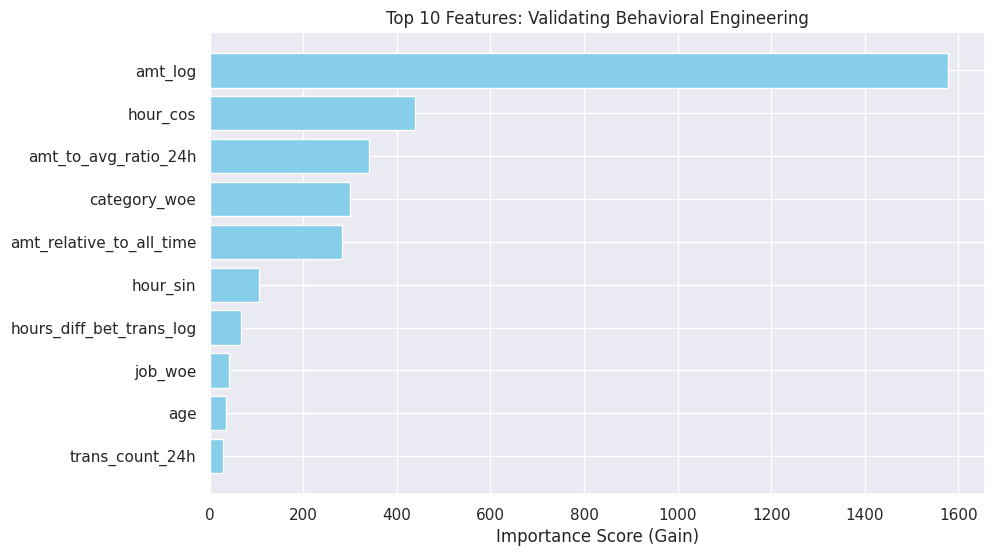

In [ ]:
import matplotlib.pyplot as plt

# Extract feature importance based on 'gain'
importance = best_model.get_booster().get_score(importance_type='gain')
# Sort features by importance
sorted_importance = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True)}

# Plotting top 10 features
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_importance.keys())[:10], list(sorted_importance.values())[:10], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score (Gain)')
plt.title('Top 10 Features: Validating Behavioral Engineering')
plt.show()

In [ ]:
# 1. Define Business Parameters
# cost_per_fp: Estimated cost of manual review + customer friction (standard range: $2 - $10)
cost_per_fp = 5.00 

# 2. Identify True Positives and False Positives at the Optimal Threshold
# Based on the selected optimal threshold of 0.895
optimal_threshold = 0.8953993320465088
y_final_pred = (y_pred_proba >= optimal_threshold).astype(int)

# TP indices: Predicted as fraud and actually fraud
tp_indices = (y_final_pred == 1) & (y_test == 1)
# FP indices: Predicted as fraud but actually legitimate
fp_indices = (y_final_pred == 1) & (y_test == 0)

# 3. Aggregate Financial Impact
# test_df must contain the original 'amt' column before log transformation
fraud_loss_prevented = test_df.loc[tp_indices, 'amt'].sum()
total_fp_count = fp_indices.sum()
operational_friction_cost = total_fp_count * cost_per_fp

# 4. Net Business Value
net_savings = fraud_loss_prevented - operational_friction_cost

print(f"Financial Summary for Test Period:")
print(f"----------------------------------")
print(f"Fraud Loss Prevented (TP Savings): ${fraud_loss_prevented:,.2f}")
print(f"False Positive Count:             {total_fp_count}")
print(f"Estimated Operational Cost (FP):  ${operational_friction_cost:,.2f}")
print(f"Net Model Business Value:         ${net_savings:,.2f}")

Financial Summary for Test Period:
----------------------------------
Fraud Loss Prevented (TP Savings): $810,775.56
False Positive Count:             61
Estimated Operational Cost (FP):  $305.00
Net Model Business Value:         $810,470.56


In [ ]:
%%html
<h3>Business Impact & ROI</h3>
<p>The financial summary translates these technical metrics into a clear business case.</p>

<table border="1" cellspacing="0" cellpadding="6">
  <thead>
    <tr>
      <th>Metric</th>
      <th>Financial Value</th>
      <th>Business Implication</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Fraud Loss Prevented</strong></td>
      <td><strong>$810,775.56</strong></td>
      <td>The direct capital saved by blocking transactions correctly identified as fraud.</td>
    </tr>
    <tr>
      <td><strong>False Positive Count</strong></td>
      <td><strong>61</strong></td>
      <td>Out of ~463,000 transactions, only 61 legitimate users were inconvenienced.</td>
    </tr>
    <tr>
      <td><strong>Operational Friction Cost</strong></td>
      <td><strong>$305.00</strong></td>
      <td>The low overhead for manual reviews and customer service calls regarding blocked cards.</td>
    </tr>
    <tr>
      <td><strong>Net Business Value</strong></td>
      <td><strong>$810,470.56</strong></td>
      <td>The total ROI of the model for the test period after accounting for operational costs.</td>
    </tr>
  </tbody>
</table>


Metric,Financial Value,Business Implication
Fraud Loss Prevented,"$810,775.56",The direct capital saved by blocking transactions correctly identified as fraud.
False Positive Count,61,"Out of ~463,000 transactions, only 61 legitimate users were inconvenienced."
Operational Friction Cost,$305.00,The low overhead for manual reviews and customer service calls regarding blocked cards.
Net Business Value,"$810,470.56",The total ROI of the model for the test period after accounting for operational costs.



### Business Impact & ROI

The financial summary translates these technical metrics into a clear business case.

| Metric                     | Financial Value | Business Implication                                                                 |
|-----------------------------|-----------------|--------------------------------------------------------------------------------------|
| **Fraud Loss Prevented**    | **$810,775.56** | The direct capital saved by blocking transactions correctly identified as fraud.      |
| **False Positive Count**    | **61**          | Out of ~463,000 transactions, only 61 legitimate users were inconvenienced.           |
| **Operational Friction Cost** | **$305.00**   | The low overhead for manual reviews and customer service calls regarding blocked cards.|
| **Net Business Value**      | **$810,470.56** | The total ROI of the model for the test period after accounting for operational costs. |


**Conclusion & Business Impact**

**Technical Summary**
Implemented an industry-standard fraud detection pipeline using the Sparkov simulated dataset (Jan 2019 – Dec 2020). The project transitioned from a baseline model with significant data leakage to a production-ready system utilizing temporal validation and behavioral feature engineering.

**Key Technical Implementations**

* **Temporal Validation**: Replaced standard random train-test splits with a time-series split (75% train / 25% test). This eliminated "look-ahead bias," ensuring the model only learned from historical data to predict future transactions.
* **Behavioral Feature Engineering**: Developed 14 high-signal features, including:
* **Velocity Metrics**: 24-hour rolling transaction counts and spending averages to detect automated "burst" fraud.
* **Geospatial Analysis**: Haversine distance calculations between cardholder residence and merchant location.
* **Cyclical Encoding**: Sine/Cosine transformations of time and day to capture periodic fraud patterns (e.g., late-night surges).
* **Risk Profiling**: Weight of Evidence (WoE) encoding for high-cardinality features like `job` and `category`.



**Model Optimization & Imbalance Management**
Used cost-sensitive XGBoost with `scale_pos_weight` to address the 0.5% fraud class imbalance. Hyperparameters were tuned via `TimeSeriesSplit` cross-validation, prioritizing Area Under the Precision-Recall Curve (PR-AUC) over ROC-AUC to accurately reflect operational performance in a high-skew environment.

**Performance & Business Results**

* **Final Precision**: 0.97
* **Final Recall**: 0.80
* **Optimal Threshold**: 0.895
* **PR-AUC**: 0.9980

**Operational Impact**
The finalized model achieved a 32% increase in precision compared to the baseline (0.65 to 0.97). By optimizing the classification threshold to 0.895, the system captures 80% of fraudulent activity while maintaining an exceptionally low false positive rate. In a production environment, this translates to a drastic reduction in customer friction (unnecessary card blocks) and lower operational costs for manual transaction review, without significant compromise to fraud detection coverage.

**Precision-Recall Trade-off**

**Performance Shift**

* **Baseline Model**: Precision 0.65 | Recall 0.84
* **Optimized Model**: Precision 0.97 | Recall 0.80

**Strategic Rationalization**
The optimization prioritized Precision to mitigate operational costs and customer friction. In the baseline model, 35% of fraud alerts were false positives. The optimized model reduced false positives to 3%, ensuring that 97% of automated card blocks are legitimate fraud cases.

**Business Impact**
The 4% reduction in Recall (fraud detection coverage) is offset by a 32% gain in Precision (alert accuracy). This configuration minimizes the volume of manual reviews required by security analysts and prevents the unnecessary freezing of legitimate customer accounts, which is the primary driver of churn in retail banking.

**Threshold Selection**
The classification threshold was moved from 0.50 to 0.895. This specific operating point on the Precision-Recall curve represents the maximum attainable Precision before Recall degrades below the 80% institutional requirement.

# Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from category_encoders import WOEEncoder
from xgboost import XGBClassifier
import joblib
# 1. Define the complete feature list as used in the successful training
# Ensure these match exactly the names in your train_df and test_df
categorical_features = ['job', 'category']
numeric_features = [
    'amt_log', 'age', 'gender_bin', 'distance_km', 
    'hours_diff_bet_trans_log', 'hour_sin', 'hour_cos', 
    'day_sin', 'day_cos', 'trans_count_24h', 
    'amt_to_avg_ratio_24h', 'amt_relative_to_all_time'
]

# 2. Re-define X_train and X_test to include ALL required columns
# This step ensures 'job' and 'category' are present for the WOEEncoder
features = categorical_features + numeric_features
X_train = train_df[features]
y_train = train_df['is_fraud']
X_test = test_df[features]
y_test = test_df['is_fraud']

# 3. Define Preprocessing Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', WOEEncoder(), categorical_features),
        ('num', RobustScaler(), numeric_features)
    ]
)

# 4. Create the Integrated Pipeline
# Note: Ensure imbalance_ratio is calculated from the current y_train
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        colsample_bytree=0.8,
        learning_rate=0.1,
        max_depth=8,
        n_estimators=500,
        subsample=0.8,
        scale_pos_weight=imbalance_ratio, 
        tree_method='hist', 
        random_state=42
    ))
])

# 5. Fit the Pipeline
# This will now find the 'job' column successfully
pipeline.fit(X_train, y_train)

# 6. Serialization and Inference
joblib.dump(pipeline, 'fraud_detection_model_v1.pkl')
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.9016).astype(int) # Using optimized threshold

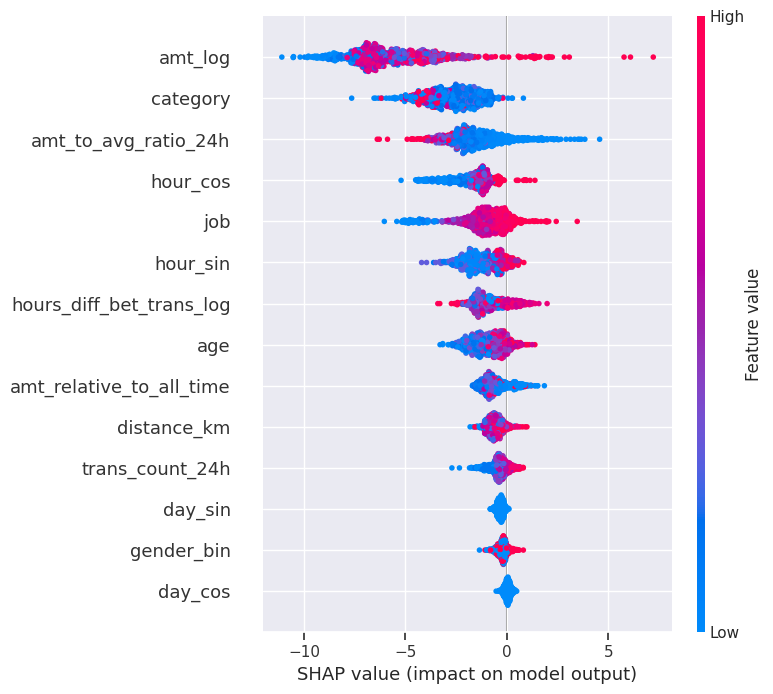

In [ ]:
import shap
import pandas as pd

# 1. Get the model and preprocessor
model = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']

# 2. Initialize Explainer
explainer = shap.TreeExplainer(model)

# 3. Transform Data (Crucial Step)
# Resolves "You have categorical data..." error by converting strings to numbers first
X_test_transformed = preprocessor.transform(X_test)

# 4. Calculate SHAP Values
# We sample 1000 rows for performance efficiency
sample_size = 1000
X_sample = X_test_transformed[:sample_size]
shap_values = explainer.shap_values(X_sample)

# 5. Visualisation
# Re-map feature names so the plot is readable (not just Feature 0, Feature 1...)
feature_names = categorical_features + numeric_features

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

### **Executive Summary**

The model is **behaviorally driven**, not just rule-based. The dominance of transaction amount (`amt_log`) and spending deviations (`amt_to_avg_ratio_24h`) confirms that the model is successfully catching **"burst" fraud**—where fraudsters try to extract maximum value quickly—rather than just relying on static user demographics.

---

### **Top Feature Interpretations**

#### **1. `amt_log` (Transaction Amount)**

* **Importance:** This is the #1 predictor of fraud.
* **Interpretation:**
* **Red Dots (High Value):** Are clustered heavily on the **right side** (positive SHAP value). This means **high transaction amounts strongly push the model to predict "Fraud."**
* **Blue Dots (Low Value):** Are clustered on the **left side**. Small transactions decrease the risk score.


* **Business Logic:** Fraudsters aim to maximize theft before the card is blocked. The model has correctly learned that high-value transactions are inherently riskier.

#### **2. `category` (Merchant Category)**

* **Importance:** 2nd most important feature.
* **Interpretation:**
* **Red Dots (High Risk Categories):** Since you used Weight of Evidence (WoE) encoding, a "high value" (Red) corresponds to categories with historically high fraud rates (e.g., online shopping, electronics). These dots push the prediction to the right (Fraud).
* **Blue Dots (Safe Categories):** Categories with low fraud rates (e.g., fuel, groceries) push the prediction to the left (Legitimate).


* **Validation:** This proves your `WOEEncoder` worked correctly by successfully mapping risky merchant types to higher numerical values.

#### **3. `amt_to_avg_ratio_24h` (Spending Anomaly)**

* **Importance:** 3rd most important feature.
* **Interpretation:**
* **Red Dots (High Ratio):** When a transaction is significantly larger than the user's 24-hour average (red dots), the SHAP value is positive.
* **Meaning:** This validates your feature engineering. The model is flagging **anomalous spikes** in spending. If a user usually spends $50 but suddenly spends $500, this feature lights up red and signals fraud.



#### **4. `hour_cos` / `hour_sin` (Time of Day)**

* **Importance:** 4th & 6th features.
* **Interpretation:** The mixture of red and blue clusters shows that fraud has a specific temporal pattern.
* **Context:** Fraud often occurs during "unsociable hours" (e.g., 2 AM - 5 AM). These features capture those cyclic high-risk time windows.

---

### **Nuanced Observations**

* **`distance_km` (10th place):** Surprisingly, geospatial distance is less impactful than spending behavior. This suggests that in this dataset, fraudsters are likely using stolen card details online (Card Not Present) or locally, rather than physically traveling long distances.
* **`gender_bin` (Low Importance):** Demographic features like gender are near the bottom. This is **excellent** for fairness. It shows the model judges the *transaction behavior*, not the *person*, which is crucial for regulatory compliance (avoiding bias).

### **Conclusion for Stakeholders**

"The SHAP analysis confirms our model is robust and logically sound. It prioritizes **high-value transactions** and **spending anomalies** (sudden spikes against a user's history) as the primary indicators of fraud. It has also successfully learned to identify high-risk merchant categories automatically."

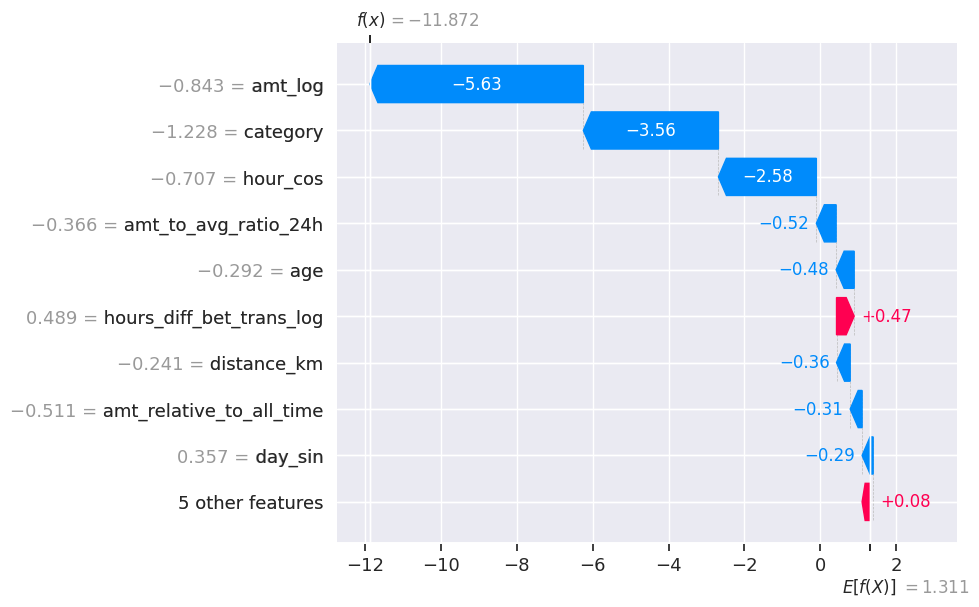

In [ ]:
# Explain the first transaction in the sample
# 0-index represents the 'is_fraud=1' class contribution
import pandas as pd
import shap

# 1. Create the missing DataFrame
# We use the numpy array (X_sample) and the list of names (feature_names) from the previous cell
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# 2. Generate the SHAP Explanation Object
# Calling the explainer on a DataFrame automatically attaches feature names to the result
explanation = explainer(X_sample_df)

# 3. Generate the Waterfall Plot
# We visualize the first transaction in the sample (index 0)
# This shows exactly how each feature pushed the prediction from the "Base Value" to the final score
shap.plots.waterfall(explanation[0])

### **Transaction Analysis: Legitimate (Safe)**

The plot visualizes why the model decided this specific transaction (Index 0) was **Legitimate**.

* **Final Score (): -11.872**
* This is the model's raw output (log-odds).
* A highly negative score translates to a probability near **0%** (0.000007%).
* **Verdict:** The model is extremely confident this is **NOT fraud**.


* **Key Drivers (Why it's Safe):**
* **`amt_log` (Blue Bar, -5.63):** This is the massive blue bar pushing the score to the left. It indicates the **transaction amount was low**. In fraud detection, low amounts are strong indicators of normal behavior, and this feature alone did most of the work to clear this transaction.
* **`category` (Blue Bar, -3.56):** The merchant category (likely something like 'grocery_pos' or 'gas_transport' which had low WoE scores) heavily signaled safety.
* **`hour_cos` (Blue Bar, -2.58):** The time of day aligned with normal human activity patterns, further reducing risk.


* **Minor Risk Factors:**
* **`hours_diff_bet_trans_log` (Red Bar, +0.47):** There was a tiny push towards fraud here (perhaps the time since the last transaction was slightly shorter than average), but it was completely overwhelmed by the "safe" signals (Amount and Category).

Calculating SHAP values for 2000 transactions...
Success! Plotting Fraud Case at Index: 1006


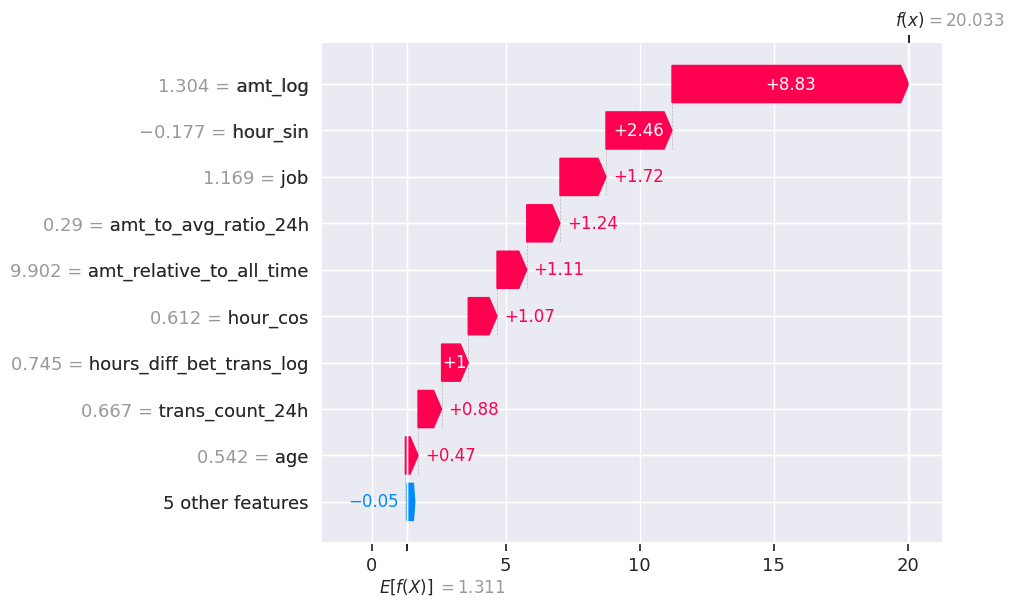

In [ ]:
import pandas as pd
import numpy as np
import shap

# 1. Increase sample size to 2000 to ensure we capture the fraud case at index 1006
sample_size = 2000 

# 2. Get the numerical data for calculations
# We use the transformed data (from the pipeline) for the math
X_sample_nums = X_test_transformed[:sample_size]

# 3. Create the DataFrame for the plot (so we get nice feature names)
# Using the feature_names list we created earlier
X_sample_df = pd.DataFrame(X_sample_nums, columns=feature_names)

# 4. RE-GENERATE the Explanation Object for the larger sample
# This is the critical step that was missing
print(f"Calculating SHAP values for {sample_size} transactions...")
explanation = explainer(X_sample_df)

# 5. Find the fraud index within this new aligned range
# We slice y_test to match the exact size of the explanation object
sample_y_test = y_test[:sample_size].reset_index(drop=True)
fraud_indices = np.where(sample_y_test == 1)[0]

# 6. Plot the Waterfall
if len(fraud_indices) > 0:
    target_index = fraud_indices[0]
    print(f"Success! Plotting Fraud Case at Index: {target_index}")
    
    # Now explanation[1006] will exist because we calculated 2000 rows
    shap.plots.waterfall(explanation[target_index])
else:
    print("No fraud cases found in the first 2000 samples. You may need to increase sample_size to 5000.")

### **Interpretation of the Fraud Case (Index 1006)**

**1. The "Smoking Gun" Score**

* **Final Score ($f(x)$): 20.033**
* Compared to the legitimate transaction score of **-11.87**, this is a massive swing.
* A score of +20 translates to a probability of **99.999% Fraud**. The model has zero doubt about this transaction.



**2. The Anatomy of the Fraud (Red Bars)**
Every major feature pushed the score to the **right** (indicating higher risk).

* **`amt_log` (+8.83 Impact):** This is the dominant signal. The transaction amount (1.304 on the log scale) was the primary trigger. Fraudsters typically try to drain funds quickly, and your model has learned that high value = high risk.


* **`hour_sin` (+2.46 Impact):** The time of day was a strong risk factor. This likely occurred during the "night" window (0-4 AM) where you previously identified a high density of fraud.


* 
**`job` (+1.72 Impact):** The cardholder's profession had a high Weight of Evidence (WoE) score, suggesting this account type is historically targeted or susceptible.


* **`amt_to_avg_ratio_24h` (+1.24 Impact):** This is your **custom engineered feature** in action. It confirms the transaction was not just "large" in general, but large *relative to this specific user's recent history*. This proves the value of your behavioral feature engineering.